In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
# Load dataset
df = pd.read_excel('OnlineRetail.xlsx')

# Display the first few rows of the dataset
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [7]:
# Data Cleaning
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display cleaned dataset info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None


In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


            Quantity                    InvoiceDate      UnitPrice  \
count  397924.000000                         397924  397924.000000   
mean       13.021823  2011-07-10 23:43:36.912475648       3.116174   
min         1.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.420210                            NaN      22.096788   

          CustomerID     TotalPrice  
count  397924.000000  397924.000000  
mean    15294.315171      22.394749  
min     12346.000000       0.000000  
25%     13969.000000       4.680000  
50%     15159.000000      11.800000  
75%     16795.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.169877     309.055588  


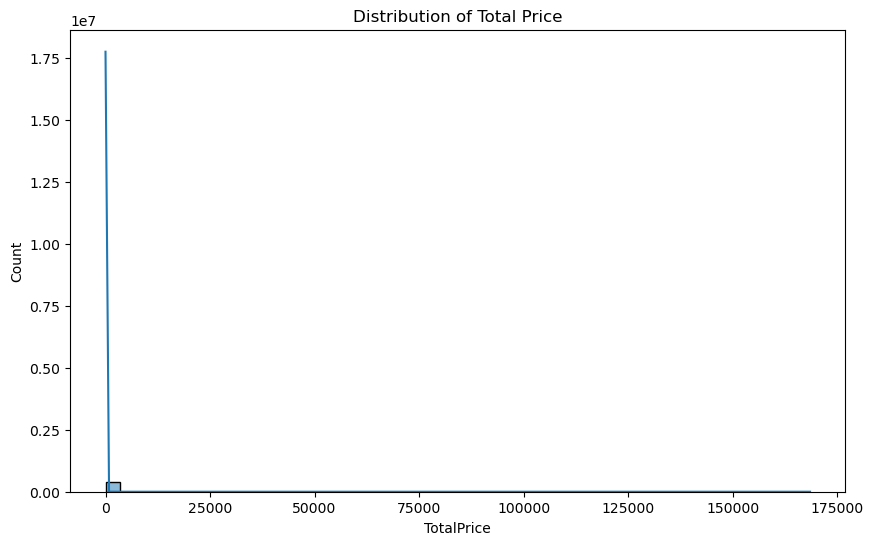

In [9]:
# Basic Statistics and Visualizations
# Summary statistics
print(df.describe())

# Distribution of TotalPrice
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title('Distribution of Total Price')
plt.show()


In [10]:
# RFM (Recency, Frequency, Monetary) Analysis
# Recency: days since last purchase
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

# Frequency: number of purchases
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary: total spend
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

# Combine RFM into a single DataFrame
rfm = pd.DataFrame({'Recency': df.groupby('CustomerID')['Recency'].min(),
                    'Frequency': frequency,
                    'Monetary': monetary})

# Display the RFM table
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [11]:
# Scaling the Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Display scaled data
print(rfm_scaled[:5])


[[ 2.33485829 -0.42467487  8.35963391]
 [-0.90519931  0.35408019  0.25104636]
 [-0.17518634 -0.03529734 -0.02854645]
 [-0.73519629 -0.42467487 -0.03296273]
 [ 2.17485544 -0.42467487 -0.19131549]]


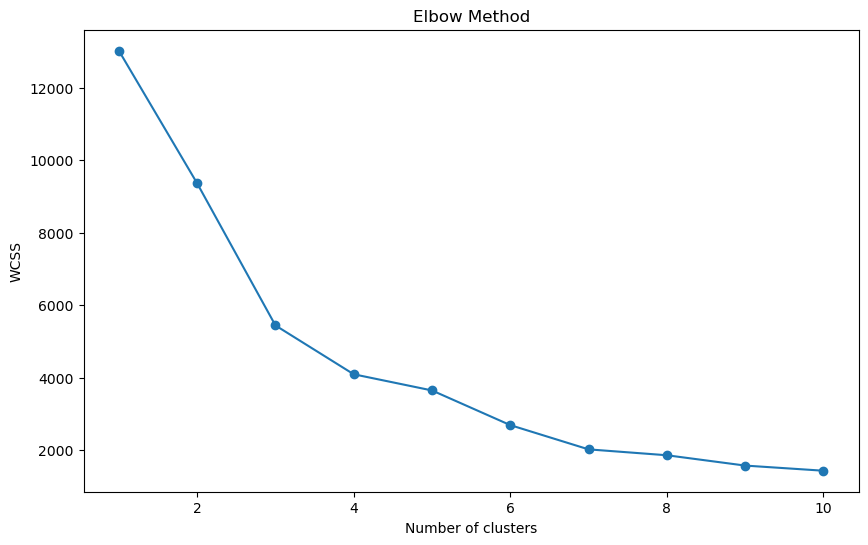

In [12]:
# Applying K-means Clustering
# Find the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [13]:
# Cluster the Data
# Apply KMeans with the optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display cluster centroids
print(pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=rfm.columns[:-1]))


      Recency  Frequency       Monetary
0   15.603774  22.004717   12422.315802
1  248.661640   1.551367     478.194732
2    7.384615  82.692308  127338.313846
3   43.957746   3.652145    1347.891996


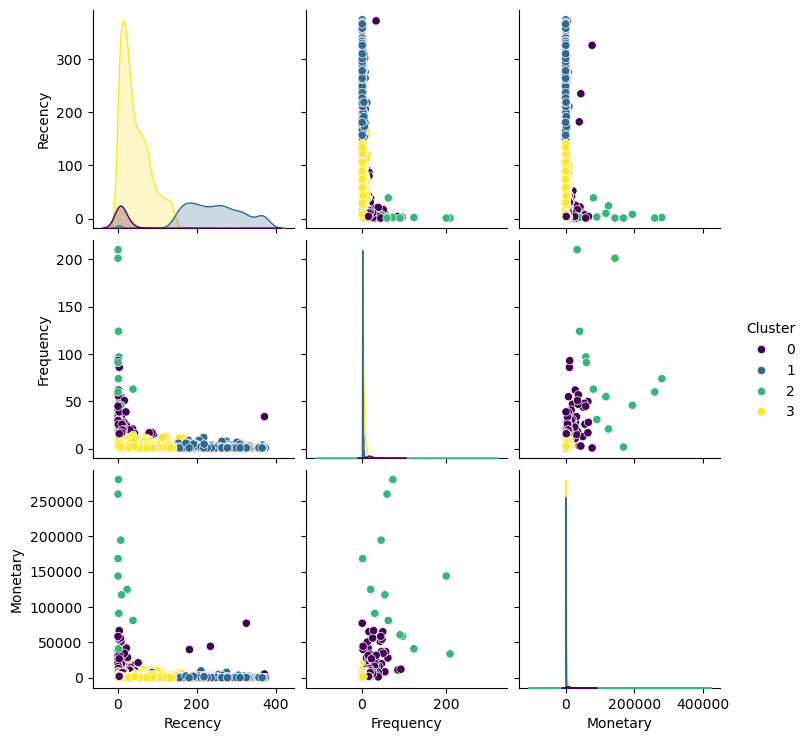

   Cluster     Recency  Frequency       Monetary  Count
0        0   15.672986  22.047393   12453.225924    211
1        1  248.564030   1.551789     478.107581   1062
2        2    7.384615  82.692308  127338.313846     13
3        3   43.910580   3.655748    1349.698298   3053


In [14]:
# Visualizing the Clusters
# Visualize clusters using pairplot
sns.pairplot(rfm, hue='Cluster', palette='viridis')
plt.show()

# Summary of each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).reset_index()

print(cluster_summary)


### Interpreting the Clusters

    Cluster 0: High Recency, Low Frequency and Monetary - Lost Customers
    Cluster 1: Low Recency, High Frequency and Monetary - Loyal Customers
    Cluster 2: Medium Recency, Medium Frequency and Monetary - Potential Loyalists
    Cluster 3: High Recency, High Frequency and Monetary - New Customers

### Recommendations

    Loyal Customers: Offer rewards and exclusive deals.
    Potential Loyalists: Engage with personalized marketing.
    New Customers: Provide introductory offers and welcome messages.
    Lost Customers: Send re-engagement campaigns.